##TASK-1
(use T4 GPU Runtime for faster learning)

In [ ]:
!wget https://zenodo.org/records/3685367/files/TinySOL.tar.gz

--2024-04-21 18:13:08--  https://zenodo.org/records/3685367/files/TinySOL.tar.gz
Resolving zenodo.org (zenodo.org)... 188.185.79.172, 188.184.103.159, 188.184.98.238, ...
Connecting to zenodo.org (zenodo.org)|188.185.79.172|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1026917185 (979M) [application/octet-stream]
Saving to: ‘TinySOL.tar.gz’

TinySOL.tar.gz      100%[===================>] 979.34M  15.7MB/s    in 65s     

2024-04-21 18:14:15 (15.0 MB/s) - ‘TinySOL.tar.gz’ saved [1026917185/1026917185]



In [ ]:
!wget https://zenodo.org/records/3685367/files/TinySOL_metadata.csv
!mkdir TinySOL
!tar -xzf TinySOL.tar.gz -C TinySOL
!rm TinySOL.tar.gz

--2024-04-21 18:14:15--  https://zenodo.org/records/3685367/files/TinySOL_metadata.csv
Resolving zenodo.org (zenodo.org)... 188.185.79.172, 188.184.98.238, 188.184.103.159, ...
Connecting to zenodo.org (zenodo.org)|188.185.79.172|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 317576 (310K) [text/plain]
Saving to: ‘TinySOL_metadata.csv’

TinySOL_metadata.cs 100%[===================>] 310.13K   419KB/s    in 0.7s    

2024-04-21 18:14:16 (419 KB/s) - ‘TinySOL_metadata.csv’ saved [317576/317576]



In [ ]:
# Importing necessary libraries
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchaudio
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
print(torchaudio.__version__)

2.2.1+cu121


In [ ]:
#Defining CNN architecture
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 6 * 6, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # print(x.shape)
        x = self.pool(torch.relu(self.conv1(x)))
        # print(x.shape)
        x = self.pool(torch.relu(self.conv2(x)))
        # print(x.shape)
        x = self.pool(torch.relu(self.conv3(x)))
        # print(x.shape)
        x = x.view(-1, 64 * 6 * 6)  # Flatten the tensor for the fully connected layers
        # print(x.shape)
        x = torch.relu(self.fc1(x))
        # print(x.shape)
        x = self.fc2(x)
        # print(x.shape)
        return x

In [ ]:
#General Dataset Class
class TinySOLDataset():
    def __init__(self, metadata_path, audio_folder):
        self.metadata = pd.read_csv(metadata_path)
        self.audio_folder = audio_folder
        self.pseudo_labels = [None] * len(self.metadata)

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        audio_file = os.path.join(self.audio_folder, self.metadata.iloc[idx]['Path'])
        waveform, sample_rate = torchaudio.load(audio_file)
        mel_spec = torchaudio.transforms.MelSpectrogram(sample_rate)(waveform)
        label = self.metadata.iloc[idx]['Instrument (in full)']
        pseudo_label = self.pseudo_labels[idx]
        return {'file': os.path.basename(audio_file),
                'audio': waveform,
                'mel': mel_spec,
                'gt': label,
                'pseudo': pseudo_label}  # Placeholder for pseudo label

    def update_pseudo_label(self, idx, pseudo_label):
        self.pseudo_labels[idx] = pseudo_label

In [ ]:
metadata_path = 'TinySOL_metadata.csv'
audio_folder = 'TinySOL'

# Defining hyperparameters
num_epochs = 30
learning_rate = 0.001
num_classes = 14  # Number of instrument classes in TinySOL dataset

# Creating dataset
dataset = TinySOLDataset(metadata_path, audio_folder)

In [ ]:
new_dataset = []
for data in dataset:
    new_dataset.append((data['mel'][0][0:50,200:250], data['gt']))  #choosing a part of mel spectrogram

/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [ ]:
# Creating dataloader
train_dataloader = DataLoader(new_dataset, batch_size=1, shuffle=True)

In [ ]:
#Train the CNN using ground truth labels
def train_model(model, criterion, optimizer, dataloader, num_epochs=30):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()

    # Initialize label encoder
    label_encoder = LabelEncoder()

    # Convert instrument names to numerical labels
    labels = ['Bass Tuba', 'French Horn', 'Trombone', 'Trumpet in C', 'Accordion', 'Contrabass', 'Violin', 'Viola',
    'Cello', 'Bassoon', 'Clarinet in Bb', 'Flute', 'Oboe', 'Alto Saxophone']
    label_encoder.fit(labels)

    train_losses = []
    train_accuracies = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs = inputs.to(device)

            # Convert instrument names to numerical labels
            labels = label_encoder.transform(labels)
            labels = torch.tensor(labels).to(device)  # Convert labels to tensor

            optimizer.zero_grad()

            outputs = model(inputs.unsqueeze(1).float())
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_acc = running_corrects.double() / len(dataloader.dataset)

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

    return model, train_losses, train_accuracies


In [ ]:
# Initializing the CNN model
model = CNN(num_classes)

# Defining loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Training the model using ground truth labels
print("Training the model using ground truth labels...")
model, train_losses, train_accuracies = train_model(model, criterion, optimizer, train_dataloader, num_epochs=num_epochs)

# Saving the trained model
torch.save(model.state_dict(), 'ground_truth_model.pth')

Training the model using ground truth labels...


Epoch 1/30: 100%|██████████| 2913/2913 [00:14<00:00, 198.15it/s]


Epoch 1/30, Loss: 2.1369, Accuracy: 0.3151


Epoch 2/30: 100%|██████████| 2913/2913 [00:09<00:00, 313.51it/s]


Epoch 2/30, Loss: 1.7636, Accuracy: 0.3938


Epoch 3/30: 100%|██████████| 2913/2913 [00:09<00:00, 312.91it/s]


Epoch 3/30, Loss: 1.6381, Accuracy: 0.4336


Epoch 4/30: 100%|██████████| 2913/2913 [00:09<00:00, 295.24it/s]


Epoch 4/30, Loss: 1.5185, Accuracy: 0.4552


Epoch 5/30: 100%|██████████| 2913/2913 [00:09<00:00, 319.18it/s]


Epoch 5/30, Loss: 1.4207, Accuracy: 0.4947


Epoch 6/30: 100%|██████████| 2913/2913 [00:11<00:00, 261.96it/s]


Epoch 6/30, Loss: 1.3182, Accuracy: 0.5266


Epoch 7/30: 100%|██████████| 2913/2913 [00:10<00:00, 281.82it/s]


Epoch 7/30, Loss: 1.2568, Accuracy: 0.5527


Epoch 8/30: 100%|██████████| 2913/2913 [00:09<00:00, 323.58it/s]


Epoch 8/30, Loss: 1.2491, Accuracy: 0.5623


Epoch 9/30: 100%|██████████| 2913/2913 [00:10<00:00, 267.23it/s]


Epoch 9/30, Loss: 1.1719, Accuracy: 0.5733


Epoch 10/30: 100%|██████████| 2913/2913 [00:08<00:00, 326.94it/s]


Epoch 10/30, Loss: 1.1020, Accuracy: 0.5939


Epoch 11/30: 100%|██████████| 2913/2913 [00:09<00:00, 323.45it/s]


Epoch 11/30, Loss: 1.0982, Accuracy: 0.6032


Epoch 12/30: 100%|██████████| 2913/2913 [00:09<00:00, 323.24it/s]


Epoch 12/30, Loss: 1.0595, Accuracy: 0.6207


Epoch 13/30: 100%|██████████| 2913/2913 [00:08<00:00, 346.45it/s]


Epoch 13/30, Loss: 1.0391, Accuracy: 0.6234


Epoch 14/30: 100%|██████████| 2913/2913 [00:09<00:00, 295.13it/s]


Epoch 14/30, Loss: 0.9709, Accuracy: 0.6416


Epoch 15/30: 100%|██████████| 2913/2913 [00:09<00:00, 322.55it/s]


Epoch 15/30, Loss: 0.9299, Accuracy: 0.6571


Epoch 16/30: 100%|██████████| 2913/2913 [00:09<00:00, 323.02it/s]


Epoch 16/30, Loss: 0.9170, Accuracy: 0.6636


Epoch 17/30: 100%|██████████| 2913/2913 [00:08<00:00, 330.93it/s]


Epoch 17/30, Loss: 0.8899, Accuracy: 0.6636


Epoch 18/30: 100%|██████████| 2913/2913 [00:10<00:00, 289.16it/s]


Epoch 18/30, Loss: 0.9018, Accuracy: 0.6862


Epoch 19/30: 100%|██████████| 2913/2913 [00:09<00:00, 310.33it/s]


Epoch 19/30, Loss: 0.8086, Accuracy: 0.7007


Epoch 20/30: 100%|██████████| 2913/2913 [00:10<00:00, 279.26it/s]


Epoch 20/30, Loss: 0.7890, Accuracy: 0.7041


Epoch 21/30: 100%|██████████| 2913/2913 [00:09<00:00, 294.04it/s]


Epoch 21/30, Loss: 0.8226, Accuracy: 0.7103


Epoch 22/30: 100%|██████████| 2913/2913 [00:09<00:00, 310.08it/s]


Epoch 22/30, Loss: 0.7344, Accuracy: 0.7223


Epoch 23/30: 100%|██████████| 2913/2913 [00:09<00:00, 293.70it/s]


Epoch 23/30, Loss: 0.7278, Accuracy: 0.7302


Epoch 24/30: 100%|██████████| 2913/2913 [00:09<00:00, 319.58it/s]


Epoch 24/30, Loss: 0.8319, Accuracy: 0.7315


Epoch 25/30: 100%|██████████| 2913/2913 [00:09<00:00, 313.46it/s]


Epoch 25/30, Loss: 0.6721, Accuracy: 0.7549


Epoch 26/30: 100%|██████████| 2913/2913 [00:09<00:00, 306.69it/s]


Epoch 26/30, Loss: 0.7146, Accuracy: 0.7425


Epoch 27/30: 100%|██████████| 2913/2913 [00:09<00:00, 308.37it/s]


Epoch 27/30, Loss: 0.6562, Accuracy: 0.7614


Epoch 28/30: 100%|██████████| 2913/2913 [00:09<00:00, 318.79it/s]


Epoch 28/30, Loss: 0.7797, Accuracy: 0.7545


Epoch 29/30: 100%|██████████| 2913/2913 [00:08<00:00, 324.89it/s]


Epoch 29/30, Loss: 0.6457, Accuracy: 0.7642


Epoch 30/30: 100%|██████████| 2913/2913 [00:08<00:00, 324.71it/s]

Epoch 30/30, Loss: 0.5965, Accuracy: 0.7738


In [ ]:
# Update the pseudo labels using trained CNN
def update_pseudo_labels(model, dataloader, dataset):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    # Initialize label encoder
    label_encoder = LabelEncoder()

    # Convert instrument names to numerical labels
    labels = ['Bass Tuba', 'French Horn', 'Trombone', 'Trumpet in C', 'Accordion', 'Contrabass', 'Violin', 'Viola',
    'Cello', 'Bassoon', 'Clarinet in Bb', 'Flute', 'Oboe', 'Alto Saxophone']
    label_encoder.fit(labels)

    with torch.no_grad():
        i = 0
        for inputs, labels in dataloader:
            inputs = inputs.to(device)

            labels = label_encoder.transform(labels)
            labels = torch.tensor(labels).to(device)  # Convert labels to tensor

            outputs = model(inputs.unsqueeze(1).float())
            _, preds = torch.max(outputs, 1)

            predicted_label = preds.item()
            dataset.update_pseudo_label(i, predicted_label)

            i+=1

update_pseudo_labels(model, DataLoader(new_dataset, batch_size=1, shuffle=False), dataset)

In [ ]:
# Train the CNN using pseudo labels
def train_model_with_pseudo_labels(model, criterion, optimizer, dataloader, num_epochs=30):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()

    pseudo_train_losses = []
    pseudo_train_accuracies = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs = inputs.to(device)

            labels = torch.tensor(labels).to(device)  # Convert labels to tensor

            optimizer.zero_grad()

            outputs = model(inputs.unsqueeze(1).float())
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_acc = running_corrects.double() / len(dataloader.dataset)

        pseudo_train_losses.append(epoch_loss)
        pseudo_train_accuracies.append(epoch_acc)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

    return model, pseudo_train_losses, pseudo_train_accuracies

In [ ]:
new_dataset_pseudo = []
for data in dataset:
    new_dataset_pseudo.append((data['mel'][0][0:50,200:250], data['pseudo'])) #choosing a part of mel spectrogram

/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [ ]:
del model
model = CNN(num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

pseudo_train_dataloader = DataLoader(new_dataset_pseudo, batch_size=1, shuffle=True)

# Training the model using pseudo labels
print("Training the model using pseudo labels...")
model, pseudo_train_losses, pseudo_train_accuracies = train_model_with_pseudo_labels(model, criterion, optimizer, pseudo_train_dataloader, num_epochs=num_epochs)

Training the model using pseudo labels...


Epoch 1/30:   0%|          | 0/2913 [00:00<?, ?it/s]<ipython-input-12-d183496f1590>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)  # Convert labels to tensor
Epoch 1/30: 100%|██████████| 2913/2913 [00:08<00:00, 347.28it/s]


Epoch 1/30, Loss: 1.9602, Accuracy: 0.3776


Epoch 2/30: 100%|██████████| 2913/2913 [00:08<00:00, 361.81it/s]


Epoch 2/30, Loss: 1.5702, Accuracy: 0.4463


Epoch 3/30: 100%|██████████| 2913/2913 [00:08<00:00, 341.97it/s]


Epoch 3/30, Loss: 1.3754, Accuracy: 0.5108


Epoch 4/30: 100%|██████████| 2913/2913 [00:08<00:00, 347.14it/s]


Epoch 4/30, Loss: 1.2627, Accuracy: 0.5503


Epoch 5/30: 100%|██████████| 2913/2913 [00:08<00:00, 359.34it/s]


Epoch 5/30, Loss: 1.1161, Accuracy: 0.5922


Epoch 6/30: 100%|██████████| 2913/2913 [00:08<00:00, 342.84it/s]


Epoch 6/30, Loss: 1.0286, Accuracy: 0.6265


Epoch 7/30: 100%|██████████| 2913/2913 [00:08<00:00, 346.07it/s]


Epoch 7/30, Loss: 0.9534, Accuracy: 0.6639


Epoch 8/30: 100%|██████████| 2913/2913 [00:08<00:00, 345.21it/s]


Epoch 8/30, Loss: 0.9096, Accuracy: 0.6818


Epoch 9/30: 100%|██████████| 2913/2913 [00:08<00:00, 362.06it/s]


Epoch 9/30, Loss: 0.8223, Accuracy: 0.6938


Epoch 10/30: 100%|██████████| 2913/2913 [00:08<00:00, 341.86it/s]


Epoch 10/30, Loss: 0.8275, Accuracy: 0.7096


Epoch 11/30: 100%|██████████| 2913/2913 [00:08<00:00, 346.05it/s]


Epoch 11/30, Loss: 0.7425, Accuracy: 0.7357


Epoch 12/30: 100%|██████████| 2913/2913 [00:08<00:00, 363.61it/s]


Epoch 12/30, Loss: 0.6782, Accuracy: 0.7456


Epoch 13/30: 100%|██████████| 2913/2913 [00:08<00:00, 346.65it/s]


Epoch 13/30, Loss: 0.6537, Accuracy: 0.7624


Epoch 14/30: 100%|██████████| 2913/2913 [00:08<00:00, 346.69it/s]


Epoch 14/30, Loss: 0.6395, Accuracy: 0.7731


Epoch 15/30: 100%|██████████| 2913/2913 [00:08<00:00, 355.77it/s]


Epoch 15/30, Loss: 0.6022, Accuracy: 0.7786


Epoch 16/30: 100%|██████████| 2913/2913 [00:08<00:00, 355.52it/s]


Epoch 16/30, Loss: 0.5535, Accuracy: 0.7978


Epoch 17/30: 100%|██████████| 2913/2913 [00:08<00:00, 344.32it/s]


Epoch 17/30, Loss: 0.5525, Accuracy: 0.7951


Epoch 18/30: 100%|██████████| 2913/2913 [00:08<00:00, 343.17it/s]


Epoch 18/30, Loss: 0.4865, Accuracy: 0.8256


Epoch 19/30: 100%|██████████| 2913/2913 [00:08<00:00, 360.39it/s]


Epoch 19/30, Loss: 0.4944, Accuracy: 0.8222


Epoch 20/30: 100%|██████████| 2913/2913 [00:08<00:00, 343.85it/s]


Epoch 20/30, Loss: 0.4400, Accuracy: 0.8438


Epoch 21/30: 100%|██████████| 2913/2913 [00:08<00:00, 339.72it/s]


Epoch 21/30, Loss: 0.4327, Accuracy: 0.8448


Epoch 22/30: 100%|██████████| 2913/2913 [00:08<00:00, 347.89it/s]


Epoch 22/30, Loss: 0.3943, Accuracy: 0.8593


Epoch 23/30: 100%|██████████| 2913/2913 [00:08<00:00, 348.06it/s]


Epoch 23/30, Loss: 0.4206, Accuracy: 0.8493


Epoch 24/30: 100%|██████████| 2913/2913 [00:08<00:00, 343.18it/s]


Epoch 24/30, Loss: 0.3731, Accuracy: 0.8661


Epoch 25/30: 100%|██████████| 2913/2913 [00:08<00:00, 339.07it/s]


Epoch 25/30, Loss: 0.3692, Accuracy: 0.8709


Epoch 26/30: 100%|██████████| 2913/2913 [00:08<00:00, 357.96it/s]


Epoch 26/30, Loss: 0.3998, Accuracy: 0.8716


Epoch 27/30: 100%|██████████| 2913/2913 [00:08<00:00, 341.00it/s]


Epoch 27/30, Loss: 0.3131, Accuracy: 0.8857


Epoch 28/30: 100%|██████████| 2913/2913 [00:08<00:00, 341.77it/s]


Epoch 28/30, Loss: 0.3689, Accuracy: 0.8723


Epoch 29/30: 100%|██████████| 2913/2913 [00:08<00:00, 349.50it/s]


Epoch 29/30, Loss: 0.3435, Accuracy: 0.8871


Epoch 30/30: 100%|██████████| 2913/2913 [00:08<00:00, 349.86it/s]

Epoch 30/30, Loss: 0.3163, Accuracy: 0.8867


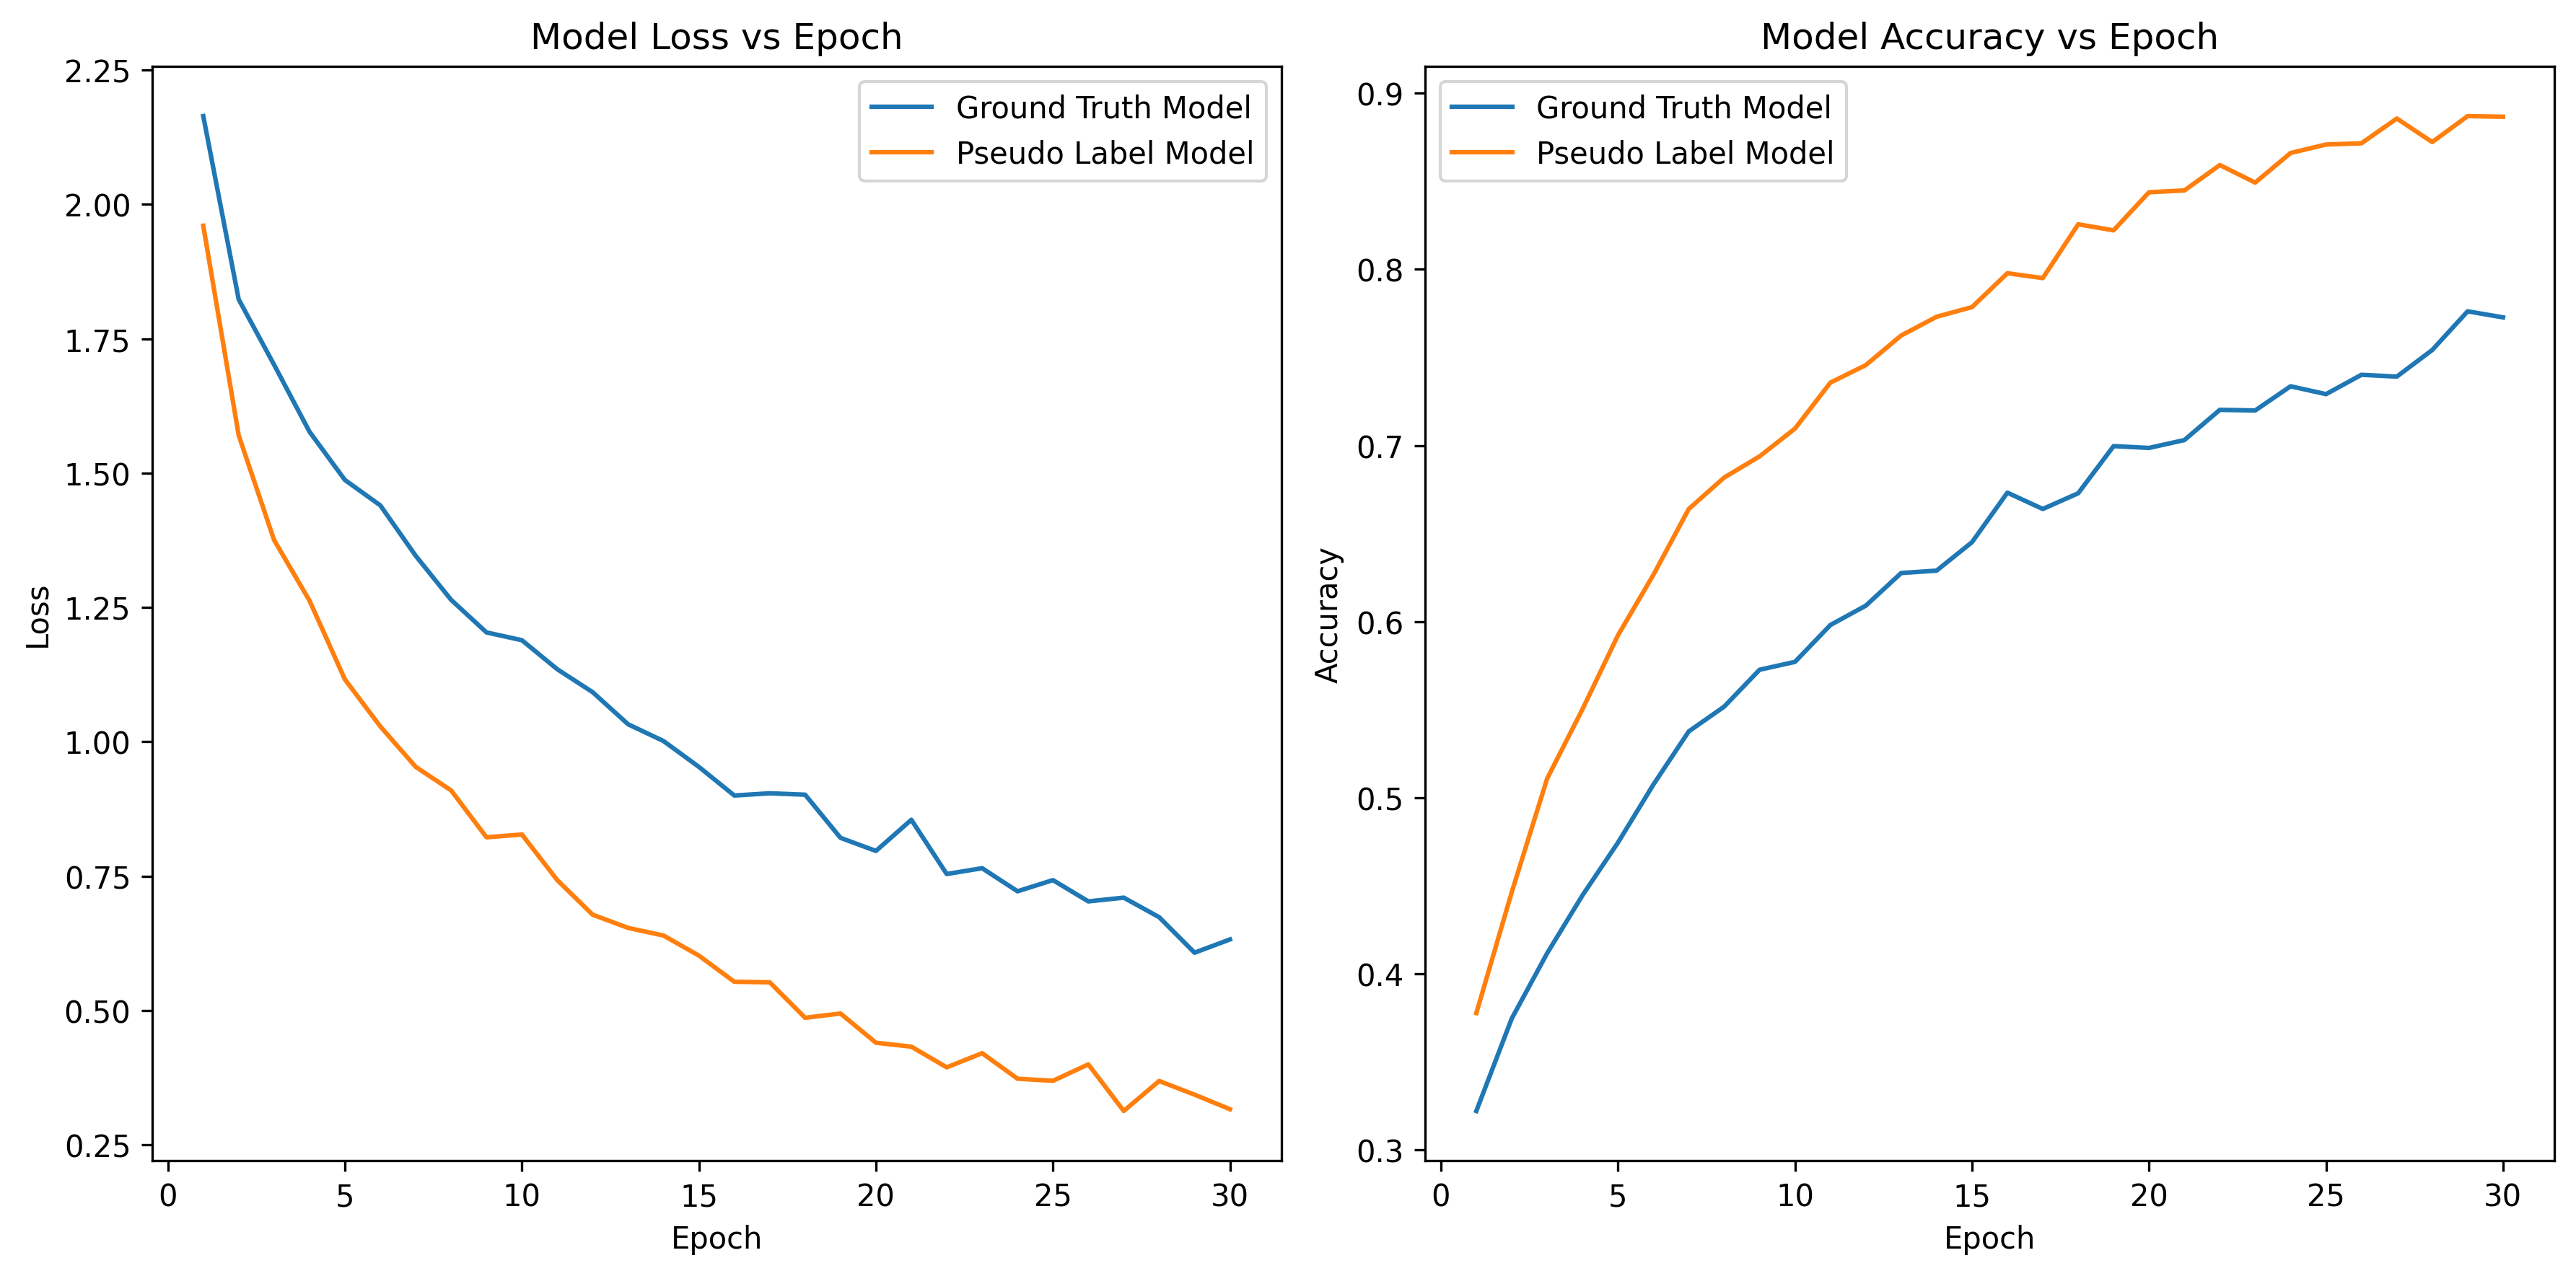

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6), dpi=300)

# Plotting model loss vs epoch
axs[0].plot(range(1, num_epochs+1), train_losses, label='Ground Truth Model')
axs[0].plot(range(1, num_epochs+1), pseudo_train_losses, label='Pseudo Label Model')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Model Loss vs Epoch')
axs[0].legend()

# Moving the tensor from GPU to CPU before converting to numpy
train_accuracies = [acc.cpu().numpy() for acc in train_accuracies]
pseudo_train_accuracies = [acc.cpu().numpy() for acc in pseudo_train_accuracies]

# Plotting model accuracy vs epoch
axs[1].plot(range(1, num_epochs+1), train_accuracies, label='Ground Truth Model')
axs[1].plot(range(1, num_epochs+1), pseudo_train_accuracies, label='Pseudo Label Model')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Model Accuracy vs Epoch')
axs[1].legend()

plt.tight_layout()
plt.show()

##MISCELLANEOUS TESTING

In [ ]:
n = 45
print(dataset[n]['gt'], dataset[n]['pseudo'])

Bass Tuba 2


In [ ]:
!pip install librosa

In [ ]:
import librosa

In [ ]:
dataset[788]['mel'][0][0:30,200:203].shape

torch.Size([30, 3])

In [ ]:
mel_shapes=[]

for i in range(2913):
    mel_shapes.append(dataset[i]['mel'].shape)
print(min(mel_shapes))

torch.Size([1, 128, 290])


In [ ]:
print(max(mel_shapes))

torch.Size([1, 128, 3580])


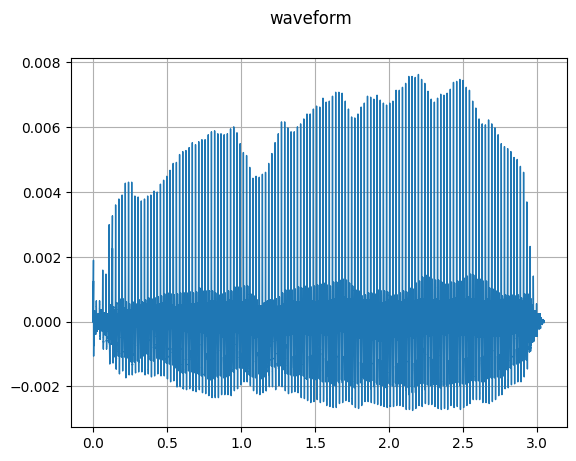

In [ ]:
def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle("waveform")

plot_waveform(dataset[0]['audio'], 44100)  #sample rate : 44100 Hz

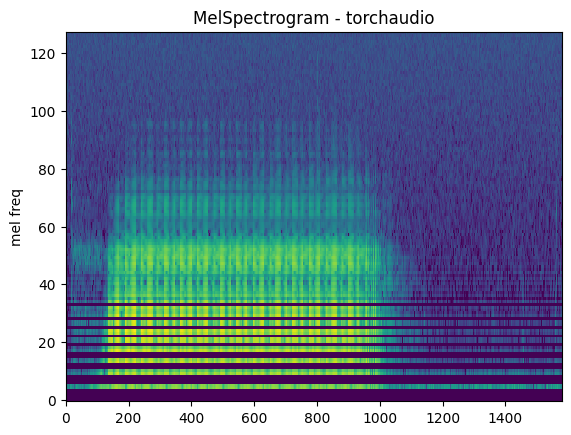

In [ ]:
def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram[0]), origin="lower", aspect="auto", interpolation="nearest")

plot_spectrogram(dataset[466]['mel'], title="MelSpectrogram - torchaudio", ylabel="mel freq")

In [ ]:
dataset[1000]['gt']

/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


'Accordion'